In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import shap

# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    aa_graph_df = pd.read_excel(xlsx, "Data")

c:\Users\923006079\AppData\Local\anaconda3\envs\revenue-forecasting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [4]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-04-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-04-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)
    df = df.rename(columns={'QtyKrt': 'Sales'})

    return df

preprocessed_omset_df = preprocess_omset(omset_df.copy())

def preprocess_aa_graph(df):
    # 1. Drop column from `Wilayah`
    df = df.drop(columns=['Wilayah'])

    # 2. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})

    # 3. Normalize string values
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.upper()

    # 4. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if re.match('.*(PULUHAN JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = re.sub('PULUHAN JT RP', 'RP', row['Dimensi'])
        elif re.match('.*(JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = re.sub('JT RP', 'RP', row['Dimensi'])
        return row
    df = df.apply(change_unit_scale, axis=1)

    # 5. Change inconsistensies of string in `Dimensi`
    df['Dimensi'] = df['Dimensi'].replace(to_replace=r'YG', value='YANG', regex=True)
    
    # 6. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]
    return df

preprocessed_aa_graph_df = preprocess_aa_graph(aa_graph_df.copy())

# Linear Regression with Exog

In [5]:
def get_data_by_kp(kp, omset_columns, aa_graph_columns):
    subset_omset_df = preprocessed_omset_df[preprocessed_omset_df['KP']==kp]
    subset_omset_df = subset_omset_df[omset_columns]
    subset_aa_graph_df= preprocessed_aa_graph_df[aa_graph_columns]
    df_with_exog = subset_omset_df.merge(subset_aa_graph_df, on=['KP', 'Periode'])
    df_with_exog = df_with_exog.pivot(index=['KP', 'Periode', 'Sales'], columns='Dimensi', values='Value').fillna(0).reset_index()
    df_with_exog = df_with_exog.rename_axis(None, axis=1)
    return df_with_exog

### Crystalin

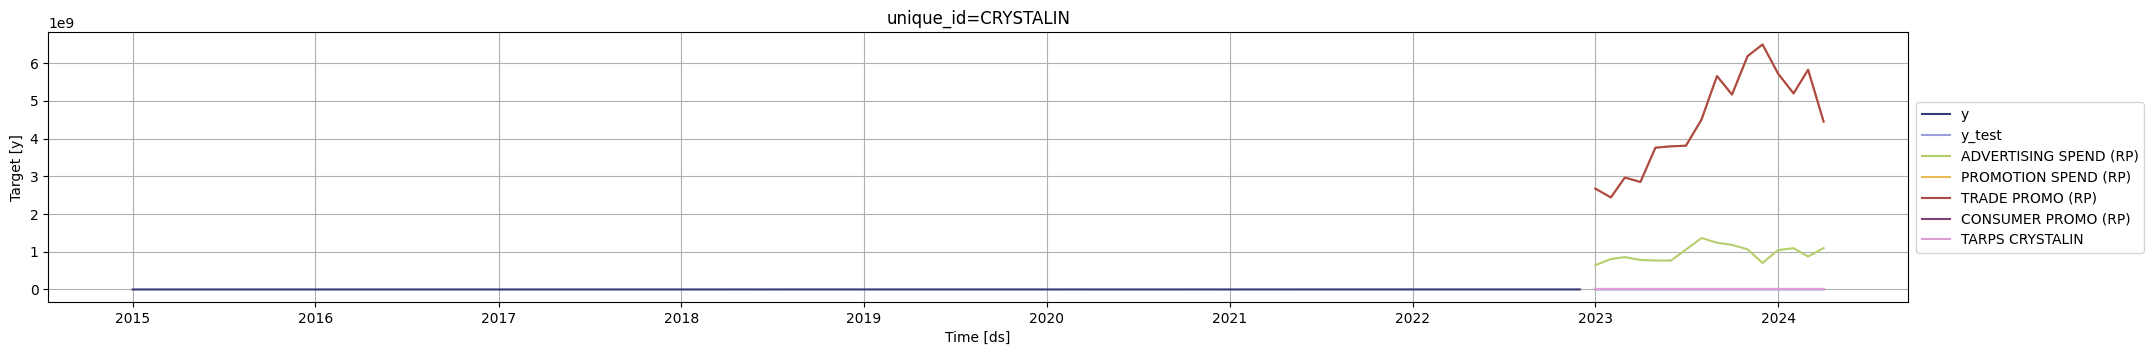

In [6]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

# arguments
kp = 'CRYSTALIN'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)', 'TARPS CRYSTALIN']

# Data for statsforecast modelling
crystalin_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
crystalin_df = crystalin_df[['Periode', 'KP', 'Sales']+exog_columns]
# Split Data
train_df = crystalin_df[crystalin_df['Periode']<=TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y'
    }).reset_index(drop=True)
test_df = crystalin_df[crystalin_df['Periode']>TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y_test'
    }).reset_index(drop=True)

StatsForecast.plot(train_df, test_df)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP),TARPS CRYSTALIN
count,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,96.0,96.0
mean,4.605758e+05,1.006339e+09,1.691731e+09,1.691731e+09,0.0,0.0
std,3.543540e+05,9.260542e+08,1.192185e+09,1.192185e+09,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,1.543590e+04,2.797839e+08,6.877192e+08,6.877192e+08,0.0,0.0
50%,5.276538e+05,8.506523e+08,1.797151e+09,1.797151e+09,0.0,0.0
75%,7.662529e+05,1.575015e+09,2.511862e+09,2.511862e+09,0.0,0.0
max,1.108416e+06,4.369210e+09,4.434798e+09,4.434798e+09,0.0,0.0


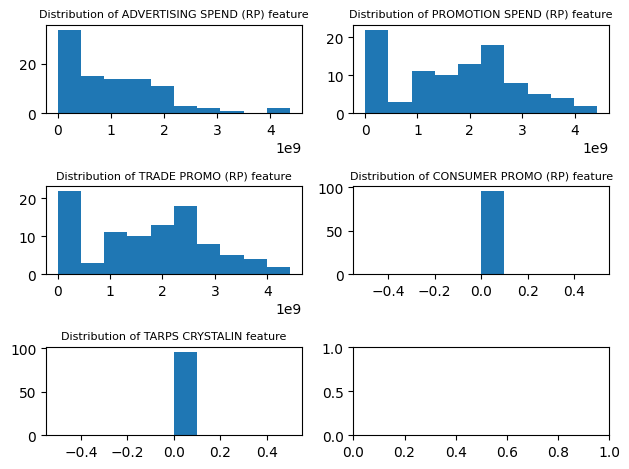

In [7]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

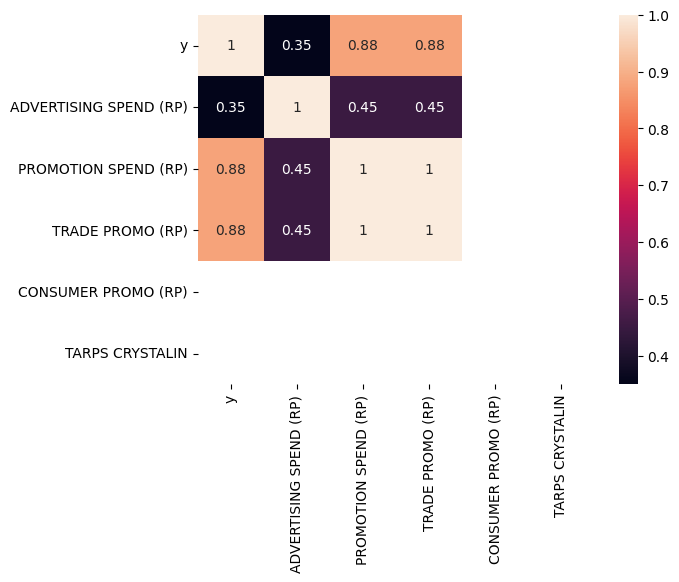

In [8]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

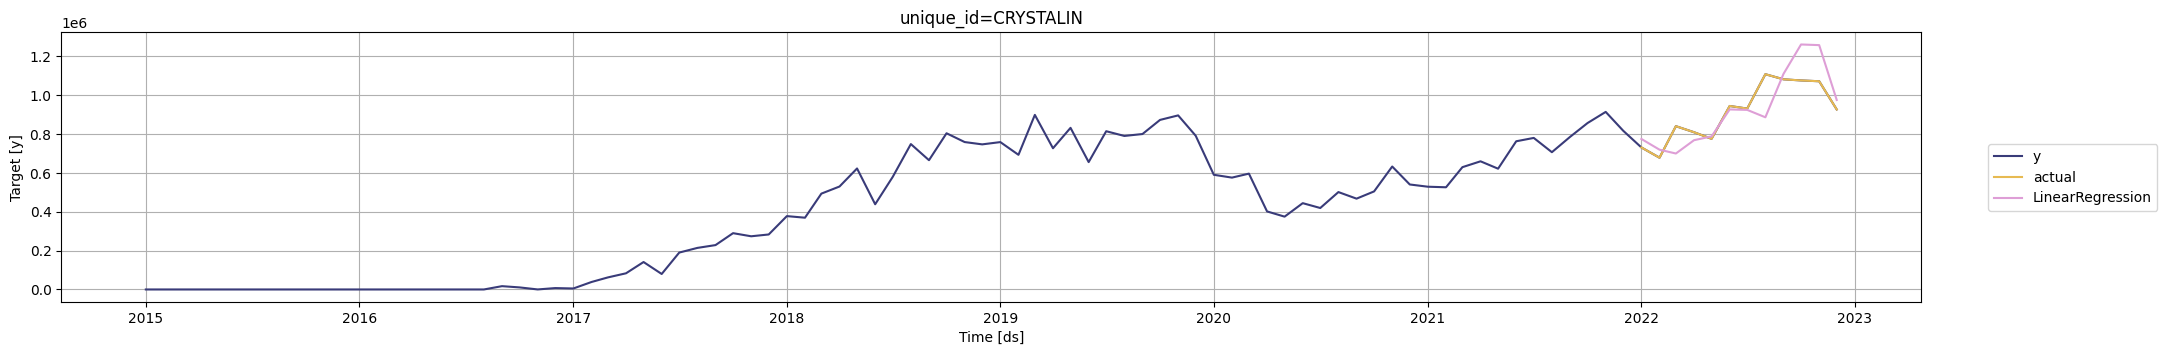

In [29]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from mlforecast.target_transforms import Differences,LocalStandardScaler
from mlforecast.lag_transforms import RollingMean, ExpandingMean
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

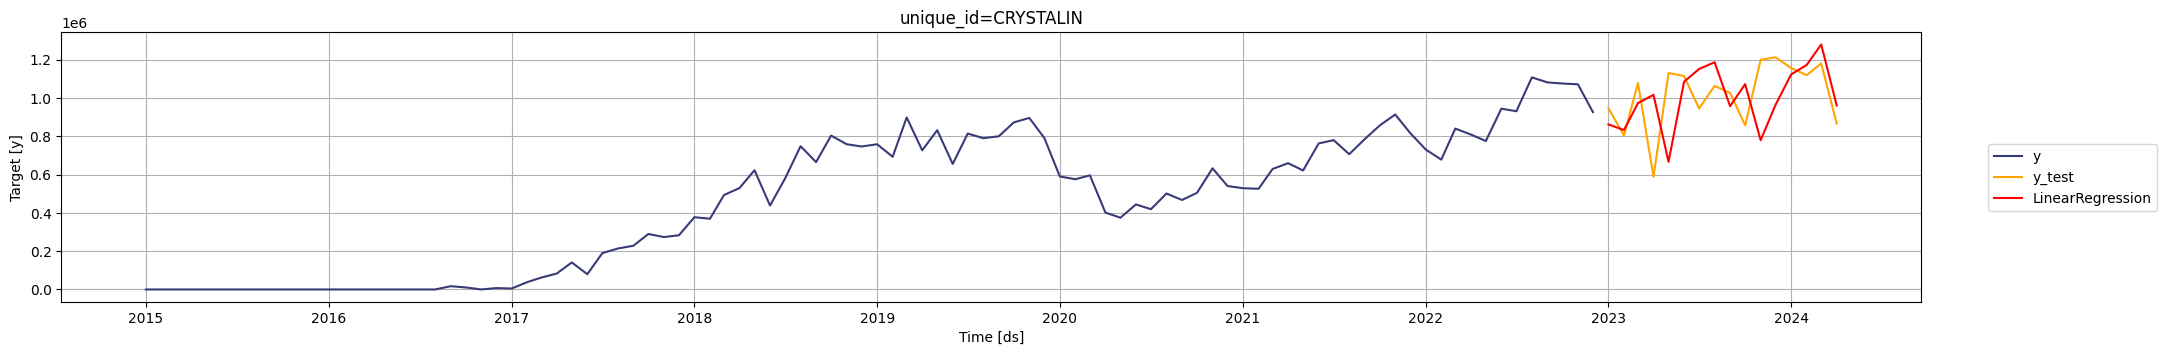

In [30]:
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]
ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

Evaluate Model

In [33]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

crossvalidation accuracy


C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target]

,unique_id,LinearRegression
0,CRYSTALIN,91.13


test accuracy


,unique_id,LinearRegression
0,CRYSTALIN,83.43


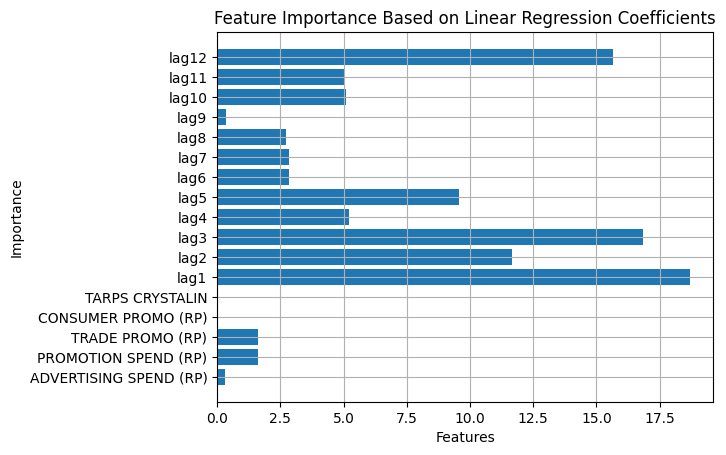

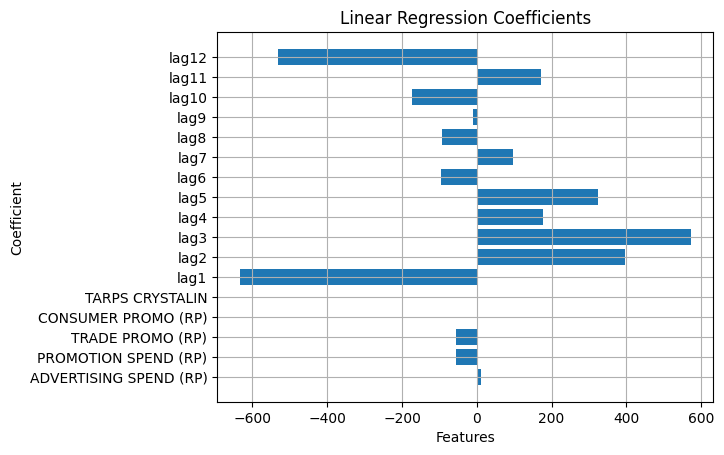

,feature,importance
5,lag1,18.68
7,lag3,16.85
16,lag12,15.64
6,lag2,11.64
9,lag5,9.56
8,lag4,5.22
14,lag10,5.11
15,lag11,5.07
11,lag7,2.83
10,lag6,2.82


In [49]:
import matplotlib.pyplot as plt
def plot_lr_feature_importance(features, coefficients):
    coefficients = abs(coefficients)
    plt.barh(features, coefficients/ sum(coefficients) * 100)
    plt.grid()
    plt.title("Feature Importance Based on Linear Regression Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

def plot_lr_coefficient(features, coefficients):
    plt.barh(features, coefficients/ sum(coefficients) * 100)
    plt.grid()
    plt.title("Linear Regression Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Coefficient")
    plt.show()

def create_feature_importance_df(features, coefficients):
    coefficients = np.abs(coefficients)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    return pd.DataFrame(
        {
            'feature': features,
            'importance': coefficients / sum(coefficients) * 100
        }
    ).sort_values(by='importance', ascending=False)

plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

### Teh Gelas Cup

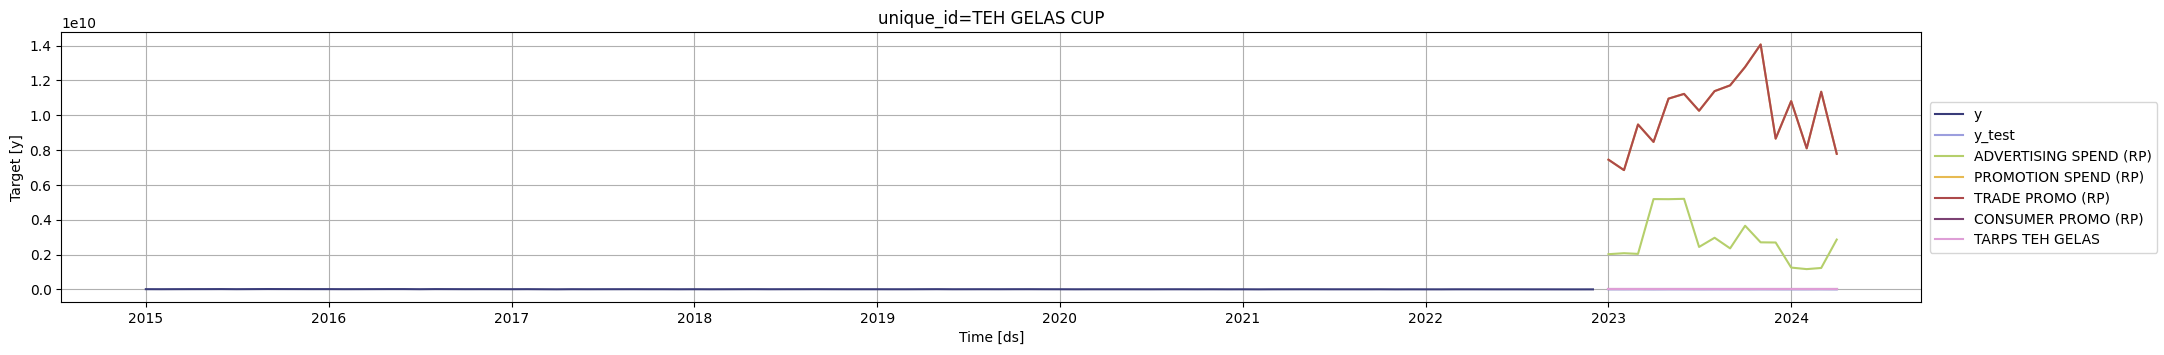

In [50]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

# arguments
kp = 'TEH GELAS CUP'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)', 'TARPS TEH GELAS']

# Data for statsforecast modelling
teh_gelas_cup_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
teh_gelas_cup_df = teh_gelas_cup_df[['Periode', 'KP', 'Sales']+exog_columns]
# Split Data
train_df = teh_gelas_cup_df[teh_gelas_cup_df['Periode']<=TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y'
    }).reset_index(drop=True)
test_df = teh_gelas_cup_df[teh_gelas_cup_df['Periode']>TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y_test'
    }).reset_index(drop=True)

StatsForecast.plot(train_df, test_df)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP),TARPS TEH GELAS
count,96.00,96.00,96.00,96.00,96.00,96.00
mean,13423688.40,4051951411.31,12136644714.73,12074144714.73,62500000.00,224.48
std,4215883.78,2465766296.05,5045558094.28,4988061736.43,166227491.55,624.21
min,5444779.72,362799445.60,1221002472.00,1221002472.00,0.00,0.00
25%,10183254.01,2250168869.50,8294017661.50,8294017661.50,0.00,0.00
50%,13133726.49,3826207441.00,11679619130.00,11679619130.00,0.00,0.00
75%,16279380.17,5327683890.00,15535957477.50,15298951687.50,0.00,0.00
max,23908951.53,17029928550.00,23714277980.00,23714277980.00,500000000.00,2351.00


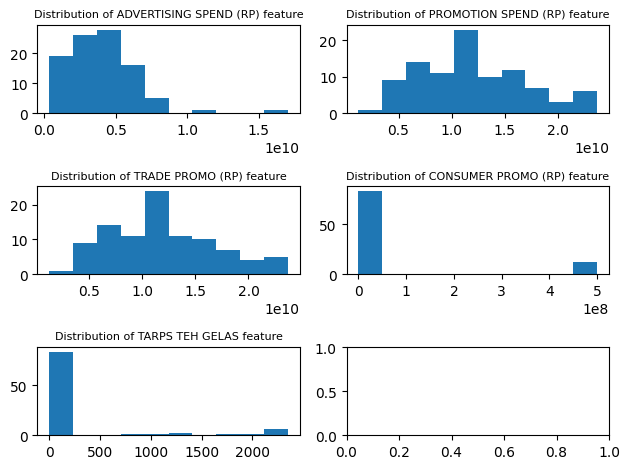

In [51]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

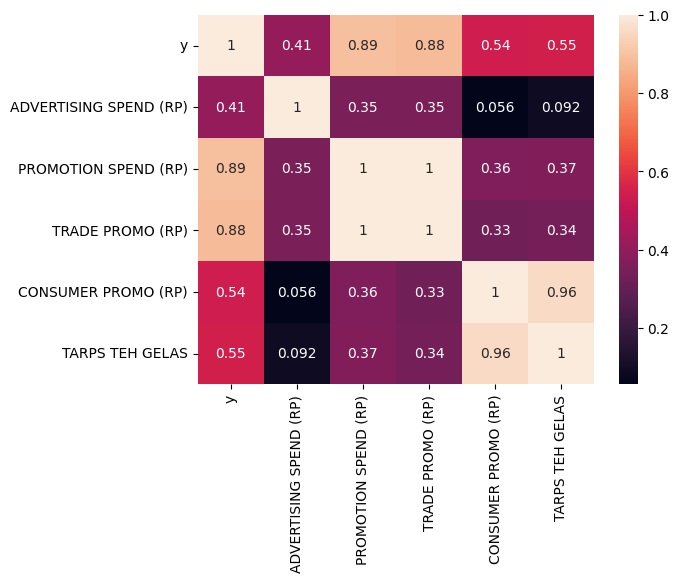

In [52]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

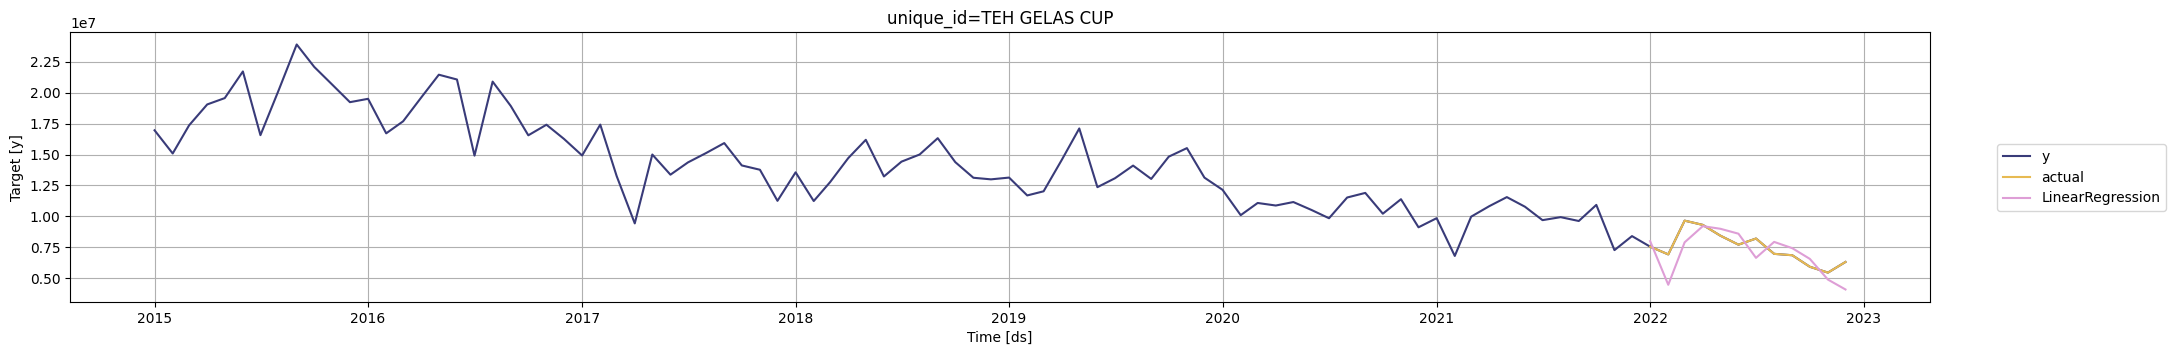

In [53]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from mlforecast.target_transforms import Differences,LocalStandardScaler
from mlforecast.lag_transforms import RollingMean, ExpandingMean
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

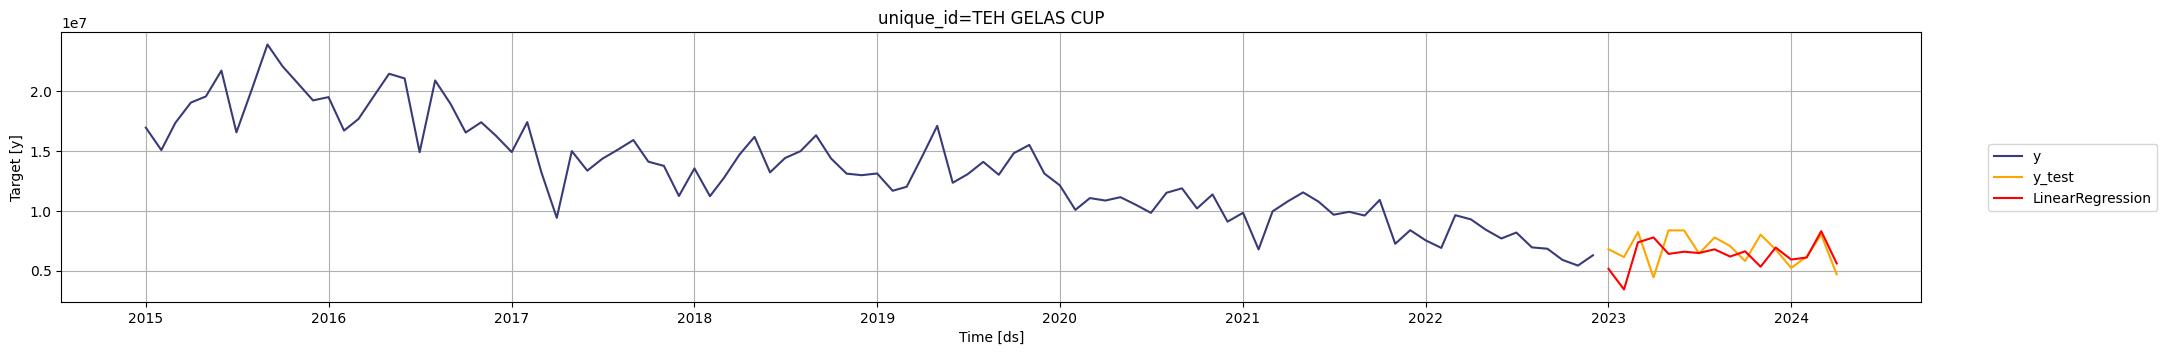

In [54]:
from dateutil.relativedelta import relativedelta
from datetime import date
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Create a ColumnTransformer to apply transformations only to 'column1'
models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

In [55]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\3299834200.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\3299834200.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target]

In [56]:
eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

In [57]:
print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

crossvalidation accuracy


,unique_id,LinearRegression
0,TEH GELAS CUP,85.73


test accuracy


,unique_id,LinearRegression
0,TEH GELAS CUP,81.74


Evaluate Model

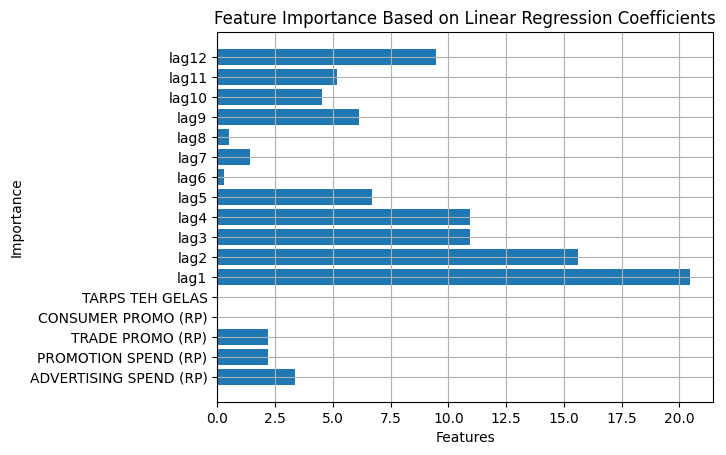

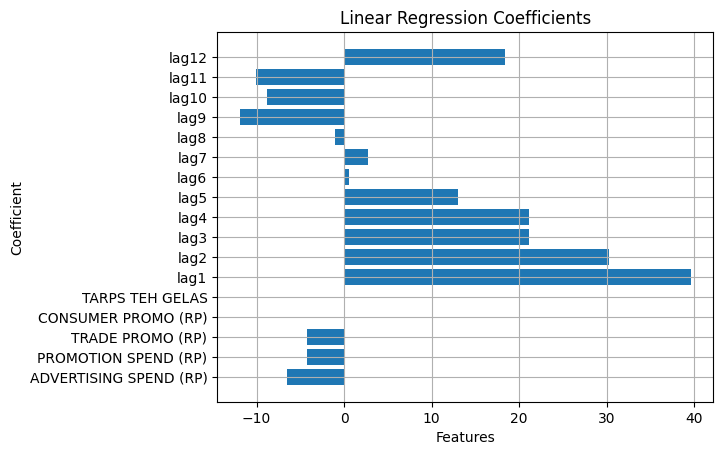

,feature,importance
5,lag1,20.43
6,lag2,15.59
7,lag3,10.92
8,lag4,10.92
16,lag12,9.48
9,lag5,6.71
13,lag9,6.15
15,lag11,5.19
14,lag10,4.54
0,ADVERTISING SPEND (RP),3.38


In [58]:
plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

### Kiranti

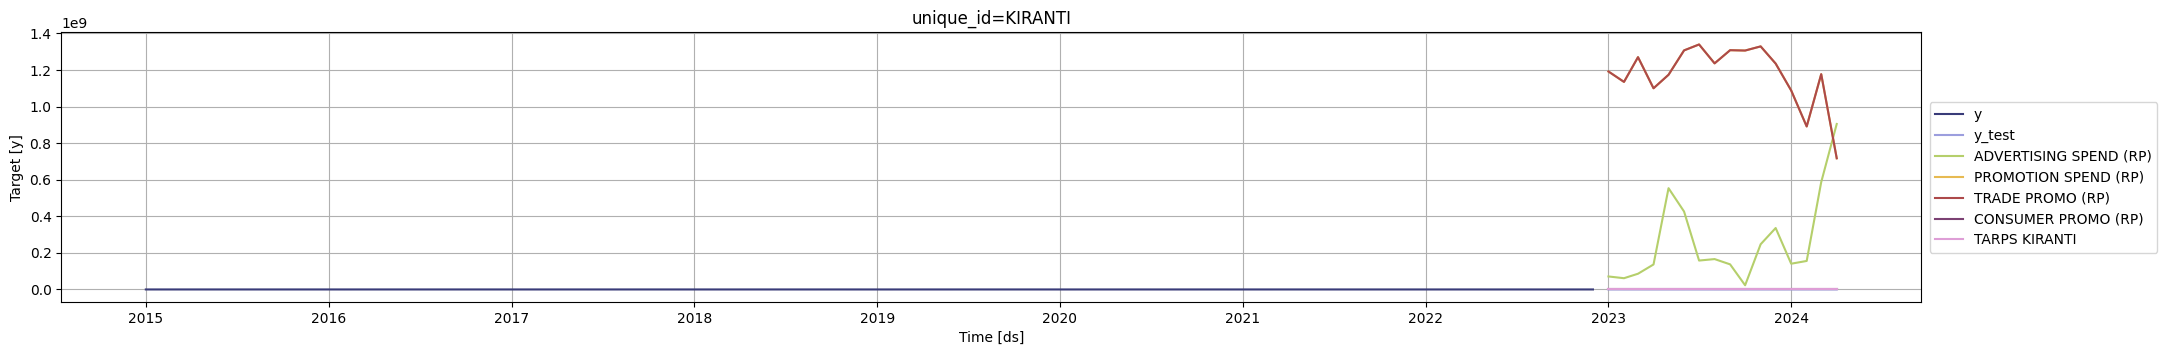

In [59]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

# arguments
kp = 'KIRANTI'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)', 'TARPS KIRANTI']

# Data for statsforecast modelling
kiranti_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
kiranti_df = kiranti_df[['Periode', 'KP', 'Sales']+exog_columns]
# Split Data
train_df = kiranti_df[kiranti_df['Periode']<=TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y'
    }).reset_index(drop=True)
test_df = kiranti_df[kiranti_df['Periode']>TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y_test'
    }).reset_index(drop=True)

StatsForecast.plot(train_df, test_df)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP),TARPS KIRANTI
count,96.00,96.00,96.00,96.00,96.00,96.00
mean,83944.80,309998808.70,669029696.31,658070129.27,10959567.04,26.79
std,14894.23,262236159.51,694227295.59,694669908.59,20238021.90,103.23
min,59359.88,662431.00,221741710.00,221741710.00,0.00,0.00
25%,74129.98,100571669.00,402552040.00,402552040.00,0.00,0.00
50%,80850.81,245959094.55,539979125.95,518578771.55,0.00,0.00
75%,93669.99,425428542.75,695018250.77,695018250.77,3144246.55,0.00
max,120760.87,1329945283.00,6630305019.00,6630305019.00,64549675.99,677.00


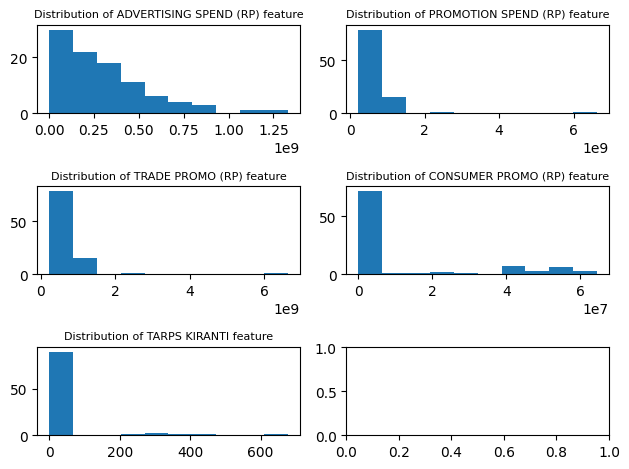

In [60]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

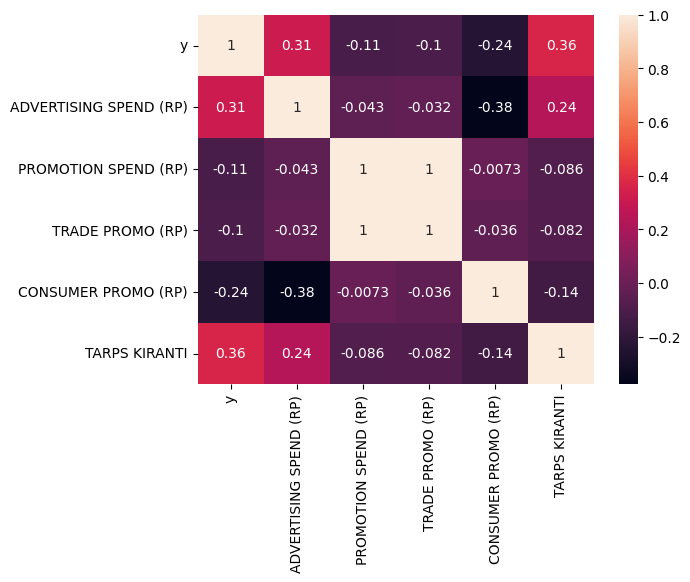

In [61]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

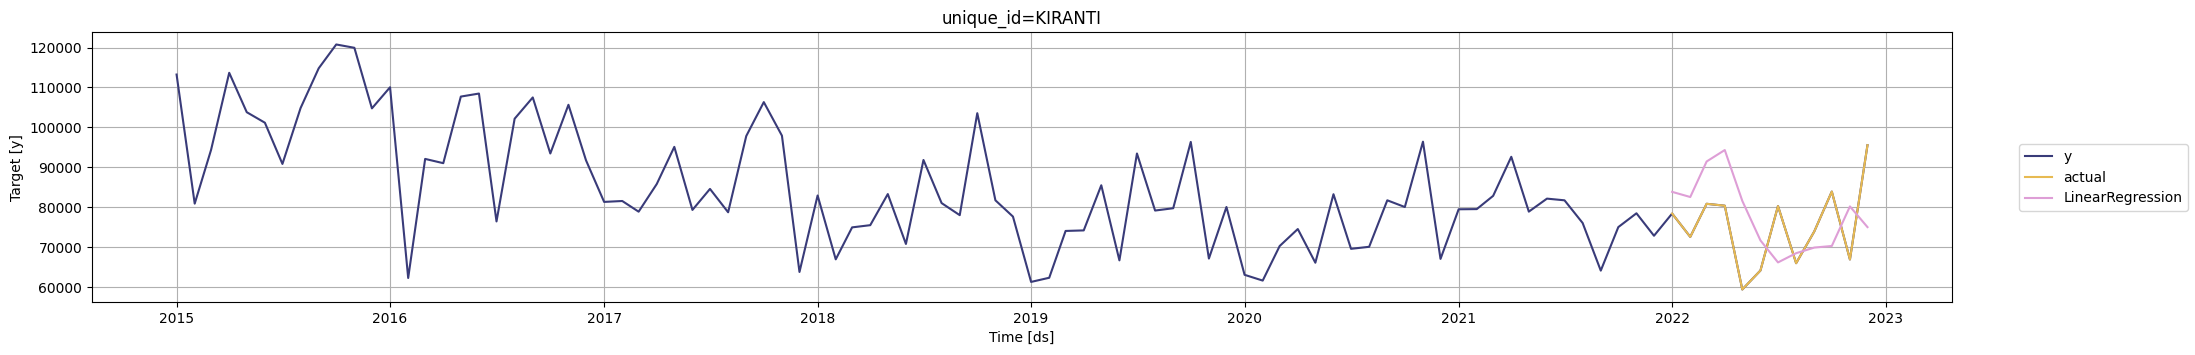

In [62]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from mlforecast.target_transforms import Differences,LocalStandardScaler
from mlforecast.lag_transforms import RollingMean, ExpandingMean
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

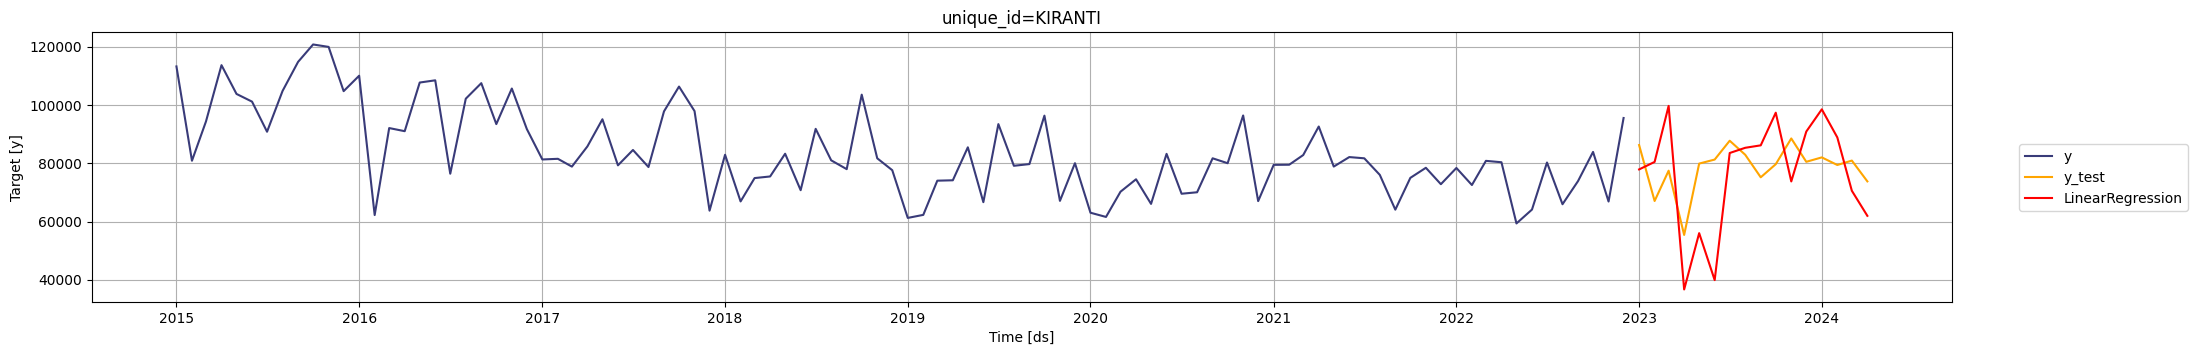

In [63]:
from dateutil.relativedelta import relativedelta
from datetime import date
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Create a ColumnTransformer to apply transformations only to 'column1'
models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

In [68]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

crossvalidation accuracy


C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target]

,unique_id,LinearRegression
0,KIRANTI,84.72


test accuracy


,unique_id,LinearRegression
0,KIRANTI,81.21


Evaluate Model

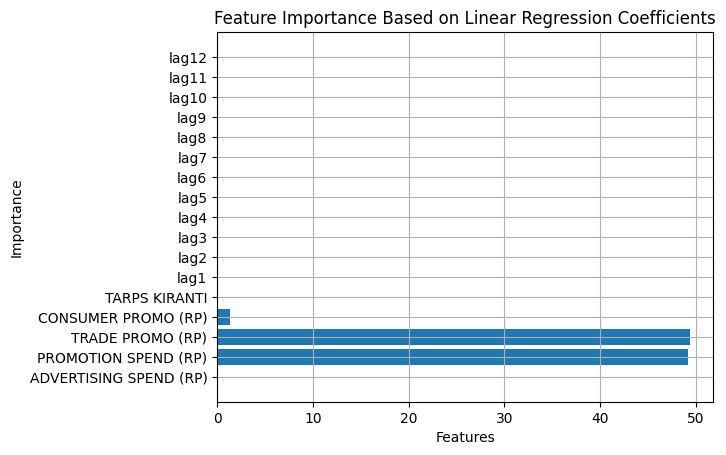

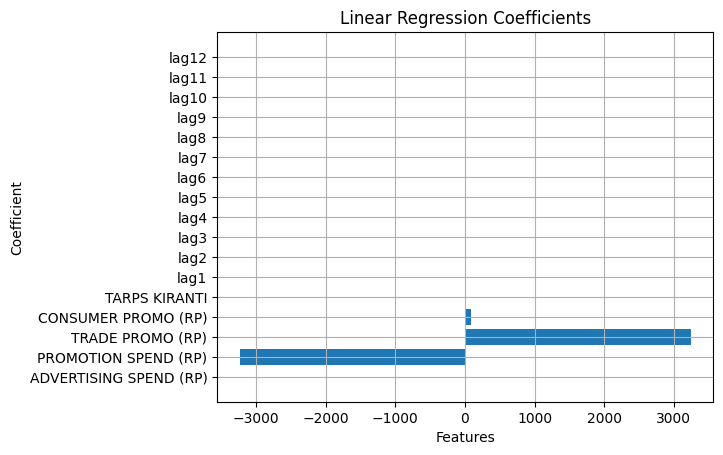

,feature,importance
2,TRADE PROMO (RP),49.37
1,PROMOTION SPEND (RP),49.24
3,CONSUMER PROMO (RP),1.39
5,lag1,0.00
6,lag2,0.00
13,lag9,0.00
8,lag4,0.00
16,lag12,0.00
15,lag11,0.00
9,lag5,0.00


In [69]:
plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

### Tango Wafer

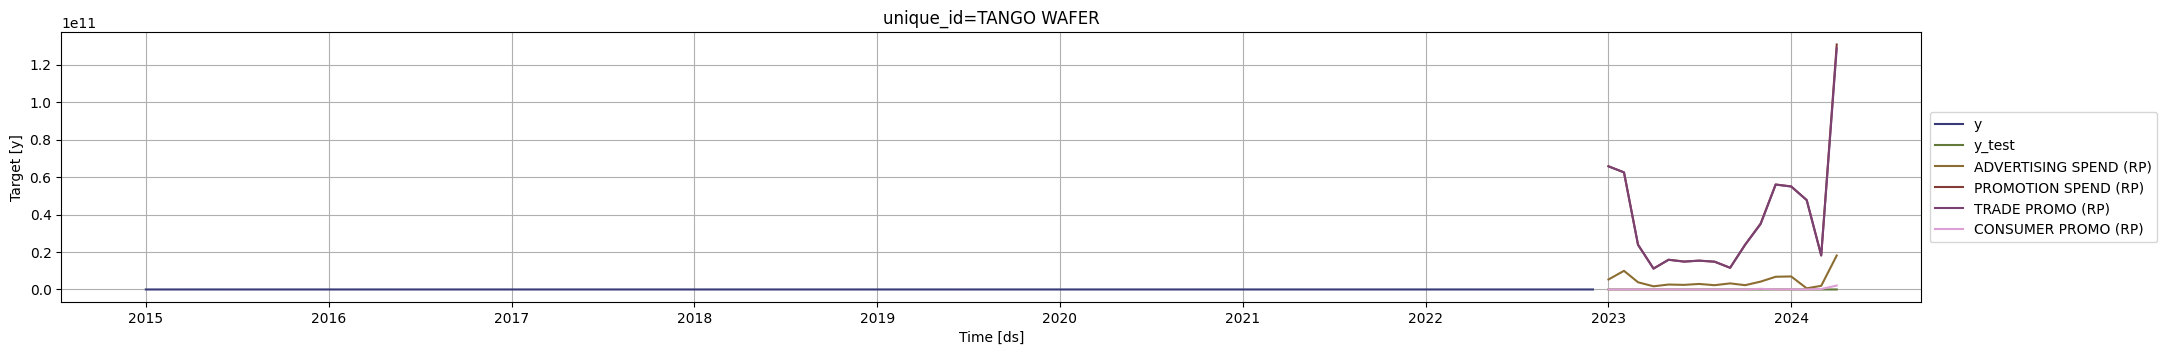

In [71]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

# arguments
kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_wafer_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_wafer_df = tango_wafer_df[['Periode', 'KP', 'Sales']+exog_columns]
# Split Data
train_df = tango_wafer_df[tango_wafer_df['Periode']<=TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y'
    }).reset_index(drop=True)
test_df = tango_wafer_df[tango_wafer_df['Periode']>TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y_test'
    }).reset_index(drop=True)

StatsForecast.plot(train_df, test_df)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP)
count,96.00,96.00,96.00,96.00,96.00
mean,1275595.38,3268092937.54,20745324703.84,20745324703.84,0.00
std,399688.08,1359816922.58,10803103680.68,10803103680.68,0.00
min,595416.85,871664005.00,6032494591.00,6032494591.00,0.00
25%,989593.51,2253013856.00,12716564790.00,12716564790.00,0.00
50%,1178934.57,3265222486.50,17665434015.00,17665434015.00,0.00
75%,1545328.26,4315182440.50,26767466645.00,26767466645.00,0.00
max,2739985.48,8377411711.00,60754921170.00,60754921170.00,0.00


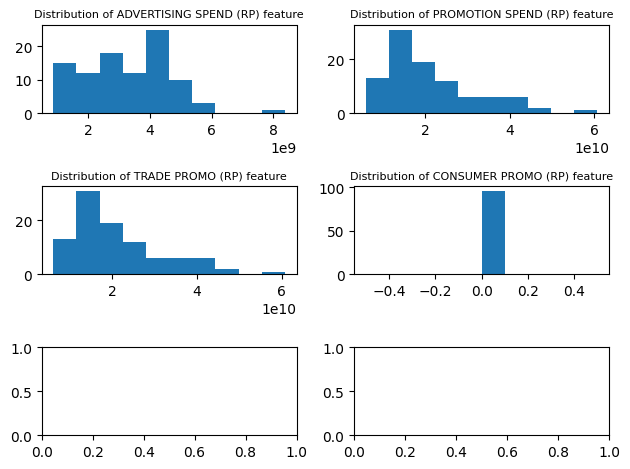

In [72]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

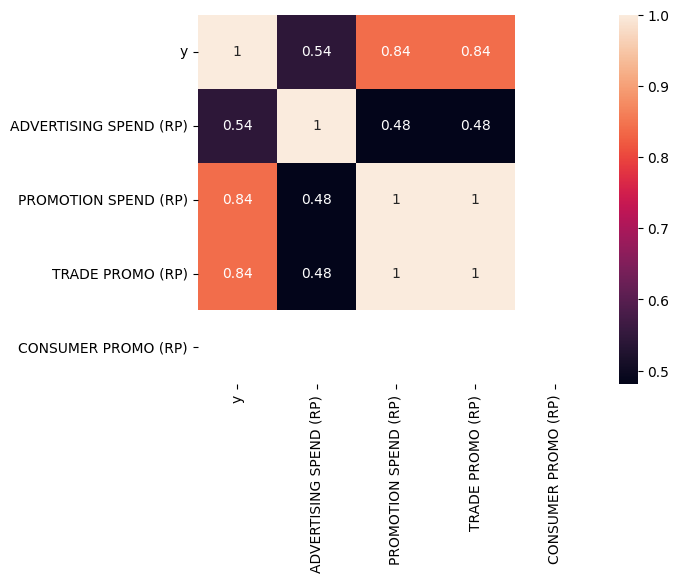

In [73]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

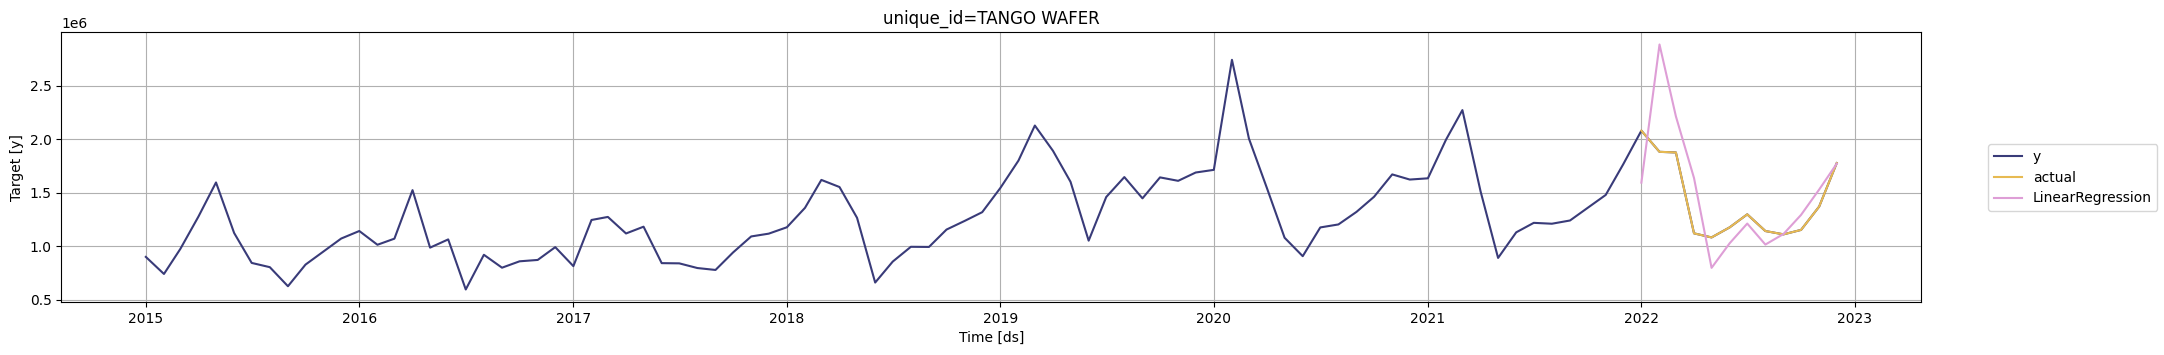

In [74]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from mlforecast.target_transforms import Differences,LocalStandardScaler
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

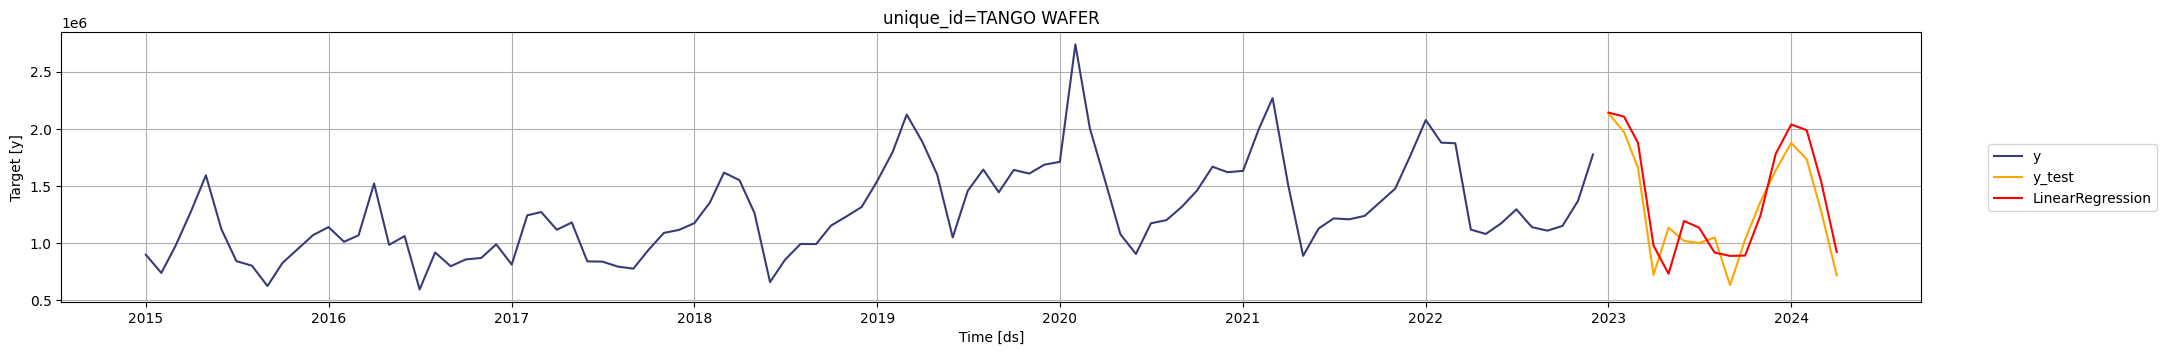

In [75]:
from dateutil.relativedelta import relativedelta
from datetime import date
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Create a ColumnTransformer to apply transformations only to 'column1'
models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

In [76]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

crossvalidation accuracy


C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\4096236871.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target]

,unique_id,LinearRegression
0,TANGO WAFER,80.68


test accuracy


,unique_id,LinearRegression
0,TANGO WAFER,85.69


Evaluate Model

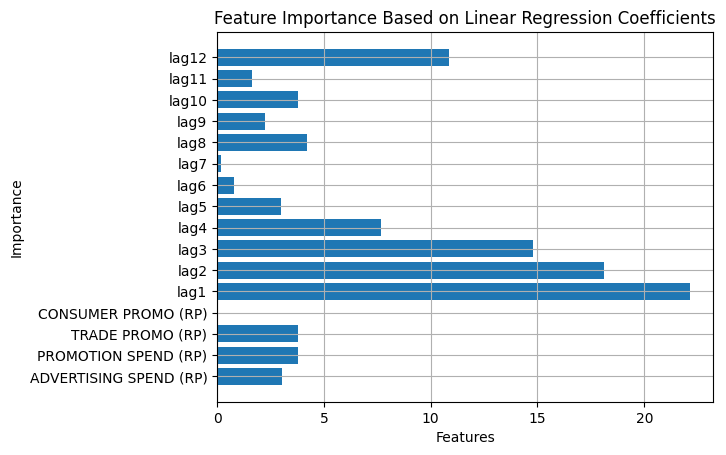

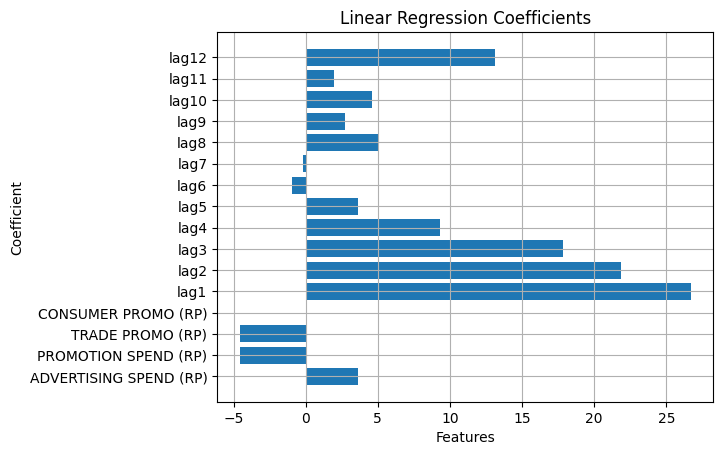

,feature,importance
4,lag1,22.12
5,lag2,18.09
6,lag3,14.81
15,lag12,10.86
7,lag4,7.69
11,lag8,4.21
1,PROMOTION SPEND (RP),3.79
2,TRADE PROMO (RP),3.79
13,lag10,3.79
0,ADVERTISING SPEND (RP),3.01


In [77]:
plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

### SG Formula

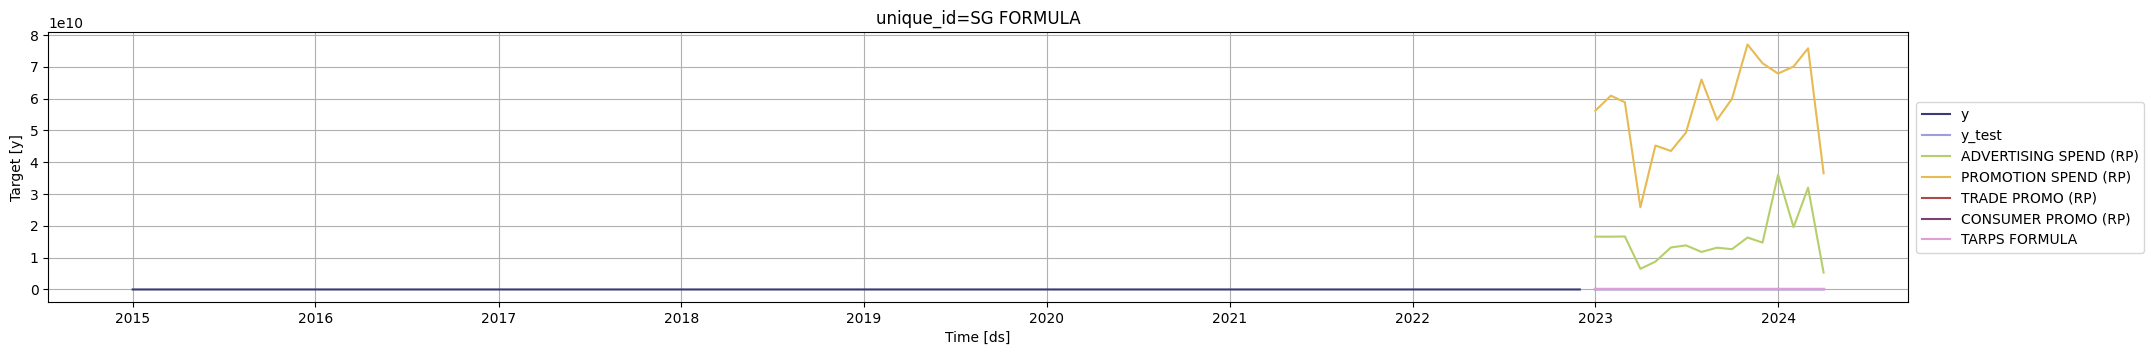

In [78]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

# arguments
kp = 'SG FORMULA'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)', 'TARPS FORMULA']

# Data for statsforecast modelling
tango_wafer_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_wafer_df = tango_wafer_df[['Periode', 'KP', 'Sales']+exog_columns]
# Split Data
train_df = tango_wafer_df[tango_wafer_df['Periode']<=TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y'
    }).reset_index(drop=True)
test_df = tango_wafer_df[tango_wafer_df['Periode']>TRAIN_CUTOFF]\
    .rename(columns={
        'Periode': 'ds',
        'KP': 'unique_id',
        'Sales': 'y_test'
    }).reset_index(drop=True)

StatsForecast.plot(train_df, test_df)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP),TARPS FORMULA
count,96.00,96.00,96.00,96.00,96.00,96.00
mean,231849.84,13739687500.00,46201250000.00,0.00,0.00,177.33
std,22100.67,8306943633.67,11254011986.38,0.00,0.00,341.67
min,162210.21,30000000.00,12470000000.00,0.00,0.00,0.00
25%,220562.88,8152500000.00,41512500000.00,0.00,0.00,0.00
50%,232619.02,12745000000.00,45710000000.00,0.00,0.00,0.00
75%,243242.73,17375000000.00,52297500000.00,0.00,0.00,157.89
max,282558.46,53020000000.00,80720000000.00,0.00,0.00,1206.00


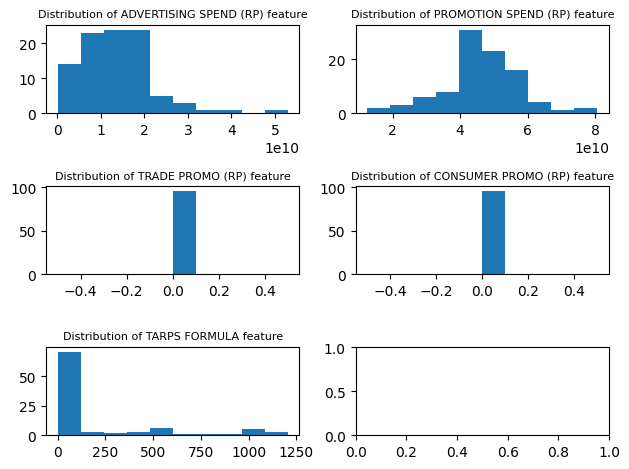

In [79]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

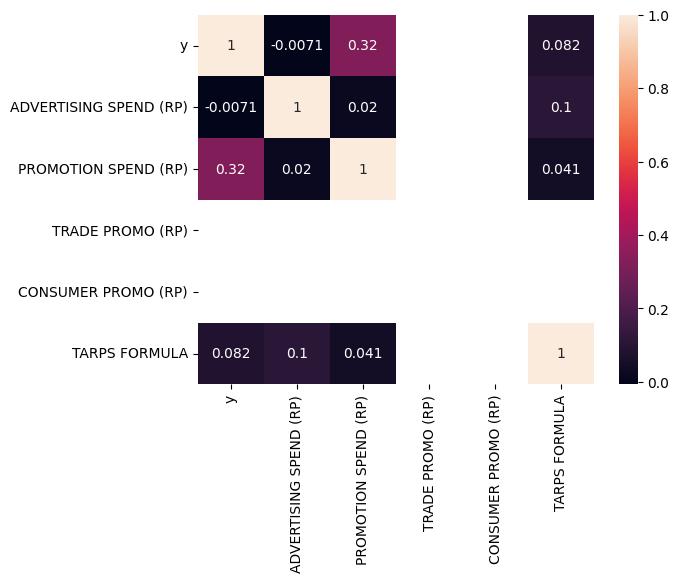

In [80]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

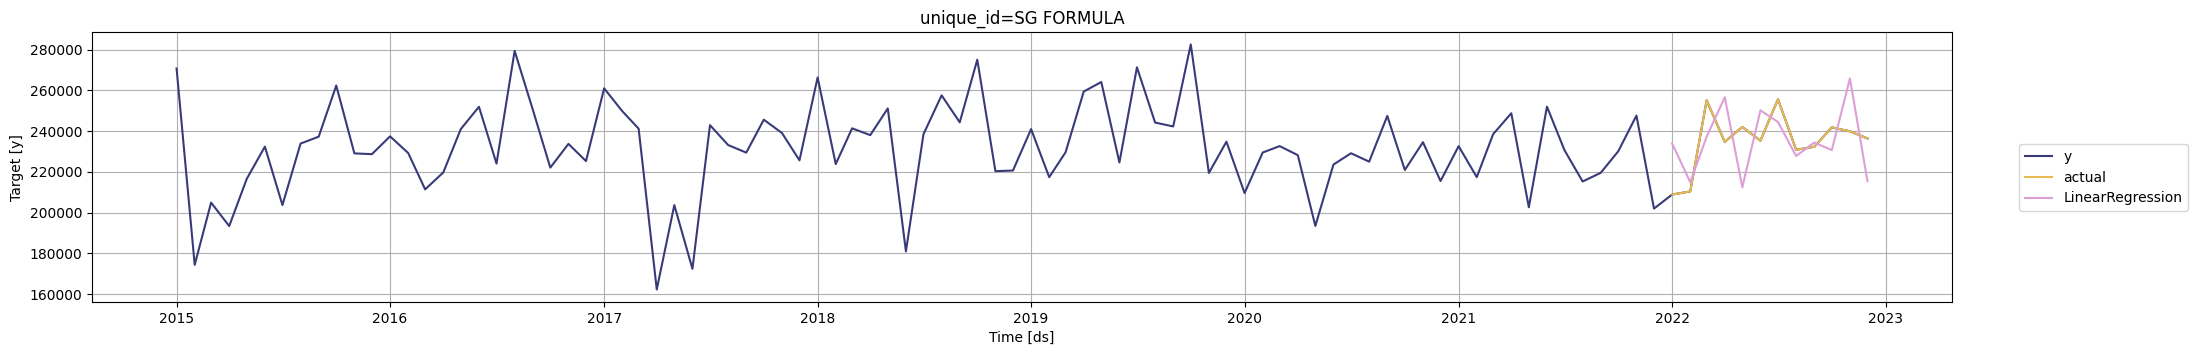

In [81]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from mlforecast.target_transforms import Differences,LocalStandardScaler
from mlforecast.lag_transforms import RollingMean, ExpandingMean
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

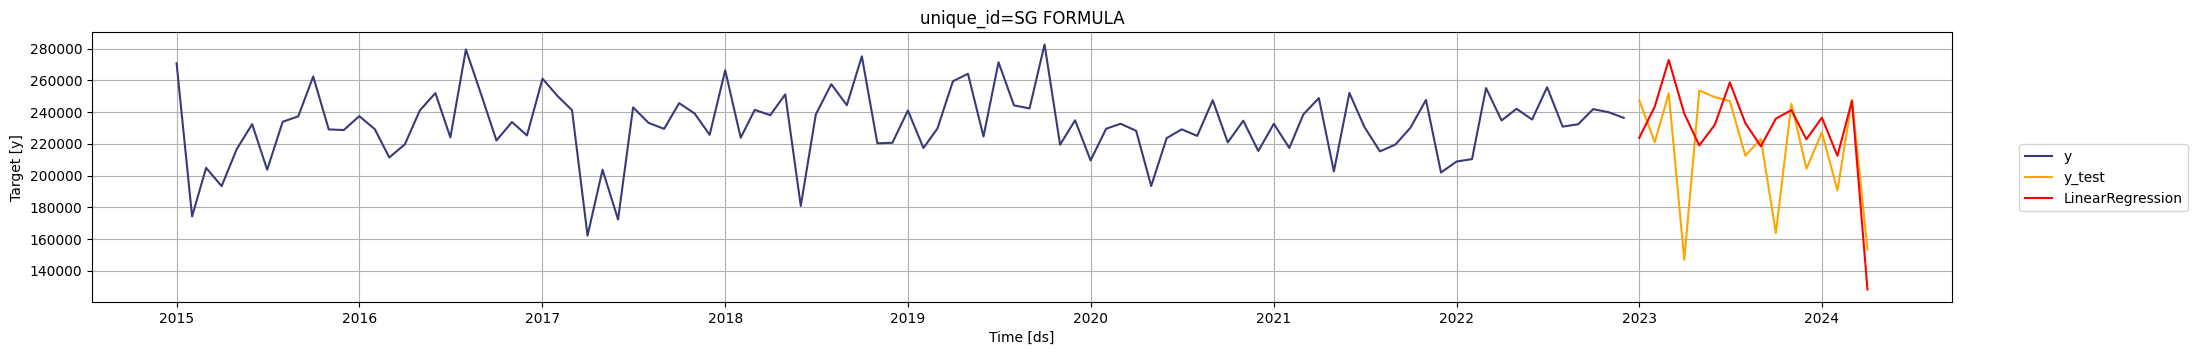

In [82]:
from dateutil.relativedelta import relativedelta
from datetime import date
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Create a ColumnTransformer to apply transformations only to 'column1'
models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

In [83]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\3299834200.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_14260\3299834200.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target]

In [84]:
eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

In [85]:
print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

crossvalidation accuracy


,unique_id,LinearRegression
0,SG FORMULA,93.32


test accuracy


,unique_id,LinearRegression
0,SG FORMULA,88.54


Evaluate Model

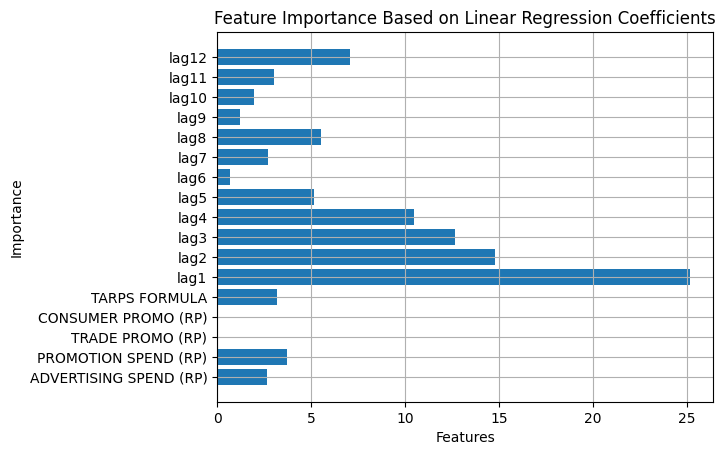

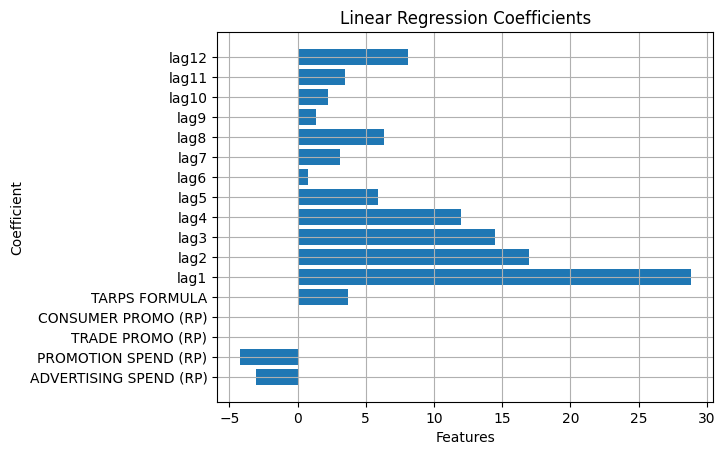

,feature,importance
5,lag1,25.16
6,lag2,14.80
7,lag3,12.65
8,lag4,10.47
16,lag12,7.10
12,lag8,5.55
9,lag5,5.14
1,PROMOTION SPEND (RP),3.70
4,TARPS FORMULA,3.20
15,lag11,3.03


In [86]:
plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

## SHAP Values

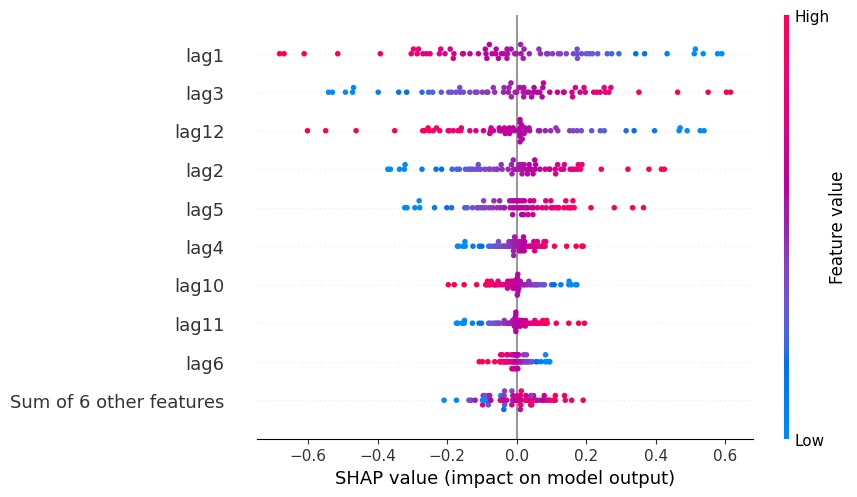

In [166]:
import shap
# 1. Train model
models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])

# 2. Prepare preprocessed training data
prep = ml.preprocess(train_df)


# 3. Evaluate model using SHAP
X = prep.drop(columns=['unique_id', 'ds', 'y'])
X200 = shap.utils.sample(X, 200)
explainer = shap.Explainer(ml.models_['LinearRegression'].predict, X200)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values)

## How model predicts?

In [168]:
from mlforecast.callbacks import SaveFeatures
save_feats = SaveFeatures()
preds = ml.predict(1, before_predict_callback=save_feats)
preds.head()


,unique_id,ds,LinearRegression
0,CRYSTALIN,2023-01-01,862244.564628


In [169]:
features = save_feats.get_features()
features.head()


,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,776591073.0,2.702260e+09,2.702260e+09,-0.5413,-0.686313,-0.859508,-1.162965,2.724722,-0.349353,0.290053,0.030084,-0.68417,0.628425,-0.560512,-0.826982


In [170]:
shap_values_predictions = explainer(features)


In [174]:
round(preds.loc[0, 'LinearRegression'], 3)


np.float64(862244.565)

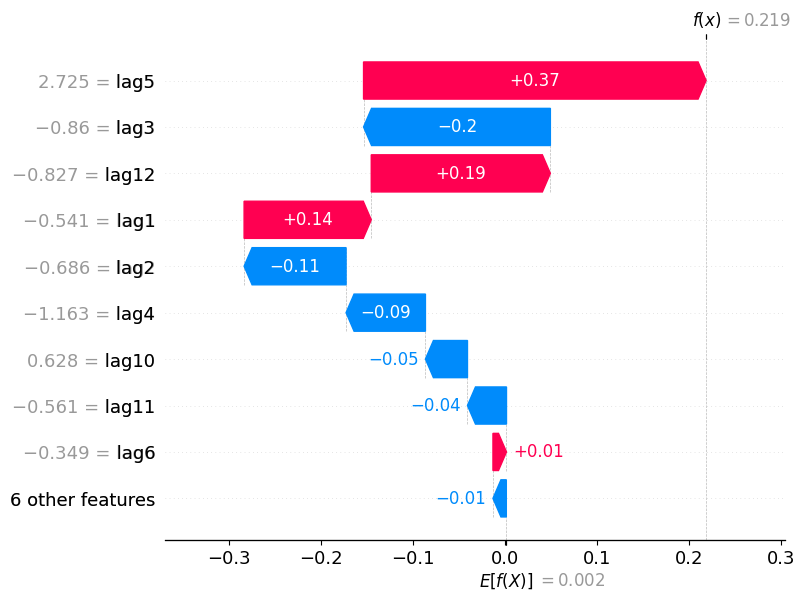

In [176]:
shap.plots.waterfall(shap_values_predictions[0])

Radial Basis Function